In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy import read
from obspy.core import UTCDateTime
from obspy.core.stream import Stream
from obspy.signal.trigger import classic_sta_lta, plot_trigger
from SeismicData import SeismicData

In [23]:
import gc

In [28]:
del normalized_station_data

In [29]:
normalized_station_data

NameError: name 'normalized_station_data' is not defined

In [2]:
root_folder = "E:\\UDINA_2018\\miniSEED"
ud01_data_folder_path = root_folder+"\\UD01"
ud02_data_folder_path = root_folder+"\\UD02"
ud03_data_folder_path = root_folder+"\\UD03"
ud04_data_folder_path = root_folder+"\\UD04"

directions_data_folders = ["6d97e2", "6d97n2", "6d97z2"]

In [3]:
def process_station_data(station_data_folder, file_num):
    import os 
    station_data = Stream()
    for direction in directions_data_folders:
        direction_stream = Stream()
        data_folder = station_data_folder+"\\"+direction
        for filename in (os.listdir(data_folder))[file_num:file_num+10]:
            input_stream=read(data_folder+"\\"+filename)
            direction_stream += input_stream
        direction_stream.merge(fill_value=0)
        station_data+=direction_stream
    return station_data

def square_sum (seismic_data):
    square_sum = list()
    for i, time in enumerate(seismic_data.times):
        summ = np.float64(0)
        for trace in seismic_data.traces:
            summ+=trace[i]*trace[i]
        summ /= seismic_data.alive_traces_count[i]
        square_sum.append((time, summ))
    return square_sum

def union_close_times(times):
    united_times = []
    for i in range(len(times)):
        if times[i].minute - times[i-1].minute < 1:
            continue
        else:
            united_times.append(times[i])
    
    return united_times
# def moving_average(a, n):
#     return np.convolve(a, np.ones((n,))/n)[(n-1):]
#     ret = np.cumsum(a, dtype=float)
#     ret[n:] = ret[n:] - ret[:-n]
#     return ret[n - 1:] / n
def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l)
 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
 
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
 
    return result

In [4]:
%%time
file_num = 40 
#file_num = 50
#file_num = 60 тут в начале есть похожее на то, что выше
#file_num = 70 тут 2 нормальных события и много мелкого мусора. 1 из 2 событий - скорее всего лаг
#file_num = 80 много как в 50
#file_num = 90 много как предыдущее
#file_num = 100 хрень
#file_num = 110 #хрень
#file_num = 120 #есть хорошее и плохое
station_data = process_station_data(ud01_data_folder_path, file_num)
station_data += process_station_data(ud02_data_folder_path, file_num)
station_data += process_station_data(ud03_data_folder_path, file_num)
station_data += process_station_data(ud04_data_folder_path, file_num)

min_filtering_frequency = 2
max_filtering_frequency = 6
station_data = station_data.detrend()
station_data = station_data.filter("bandpass", freqmin=min_filtering_frequency,freqmax = max_filtering_frequency)



C:\ProgramData\Anaconda3\lib\site-packages\obspy\signal\detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


Wall time: 10.8 s


In [5]:
%%time
normalized_station_data = station_data.copy()
for trace in normalized_station_data:
    trace.data = trace.data/np.max(trace.data)
seismic_data = SeismicData(normalized_station_data)
squareSum = square_sum(seismic_data)
x = list()
y = list()

for item in squareSum:
    x.append(item[0])
    y.append(item[1])

m=3000
x_av = np.asarray(x.copy())
y_av = np.asarray(moving_average(y.copy(), m))

Station data preprocessing...
max trace = .6D97..HHE | 2018-05-07T16:00:00.000000Z - 2018-05-08T01:59:59.990000Z | 100.0 Hz, 3600000 samples
max trace times = [UTCDateTime(2018, 5, 7, 16, 0) UTCDateTime(2018, 5, 7, 16, 0, 0, 10000)
 UTCDateTime(2018, 5, 7, 16, 0, 0, 20000) ...
 UTCDateTime(2018, 5, 8, 1, 59, 59, 970000)
 UTCDateTime(2018, 5, 8, 1, 59, 59, 980000)
 UTCDateTime(2018, 5, 8, 1, 59, 59, 990000)]
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessing...
Trace preprocessing finished
Trace preprocessi

In [21]:
from scipy.signal import find_peaks
peaks, _ = find_peaks(y_av, distance=9000, height=0.007)
print('len peaks = {}'.format(len(peaks)))
lpeaks = np.asarray(peaks)
x_av = np.asarray(x_av)

len peaks = 5


In [18]:
lpeaks

array([2064005, 2767101, 3305880], dtype=int64)

In [7]:
times = station_data[0].times("utcdatetime")
peaks_times = times[lpeaks]
filtered_times = union_close_times(peaks_times)
filtered_times.append(peaks_times[len(peaks_times)-1])
print(filtered_times)

[UTCDateTime(2018, 5, 7, 16, 1, 50, 910000), UTCDateTime(2018, 5, 7, 16, 3, 2, 650000), UTCDateTime(2018, 5, 7, 16, 4, 2, 790000), UTCDateTime(2018, 5, 7, 16, 5, 9, 560000), UTCDateTime(2018, 5, 7, 16, 6, 9, 610000), UTCDateTime(2018, 5, 7, 16, 7, 14, 130000), UTCDateTime(2018, 5, 7, 16, 8, 36, 900000), UTCDateTime(2018, 5, 7, 16, 10, 12, 230000), UTCDateTime(2018, 5, 7, 16, 11, 13, 590000), UTCDateTime(2018, 5, 7, 16, 12, 56, 900000), UTCDateTime(2018, 5, 7, 16, 14, 36, 70000), UTCDateTime(2018, 5, 7, 16, 16, 1, 720000), UTCDateTime(2018, 5, 7, 16, 17, 4, 440000), UTCDateTime(2018, 5, 7, 16, 18, 46, 680000), UTCDateTime(2018, 5, 7, 16, 19, 58, 150000), UTCDateTime(2018, 5, 7, 16, 20, 59, 400000), UTCDateTime(2018, 5, 7, 16, 22, 9, 280000), UTCDateTime(2018, 5, 7, 16, 23, 9, 430000), UTCDateTime(2018, 5, 7, 16, 24, 12, 420000), UTCDateTime(2018, 5, 7, 16, 26, 5, 620000), UTCDateTime(2018, 5, 7, 16, 27, 13, 720000), UTCDateTime(2018, 5, 7, 16, 28, 13, 820000), UTCDateTime(2018, 5, 7, 16

In [ ]:
xticks = [x.datetime.strftime("%Y-%m-%d %H:%M:%S") for x in  x_av][::60000]

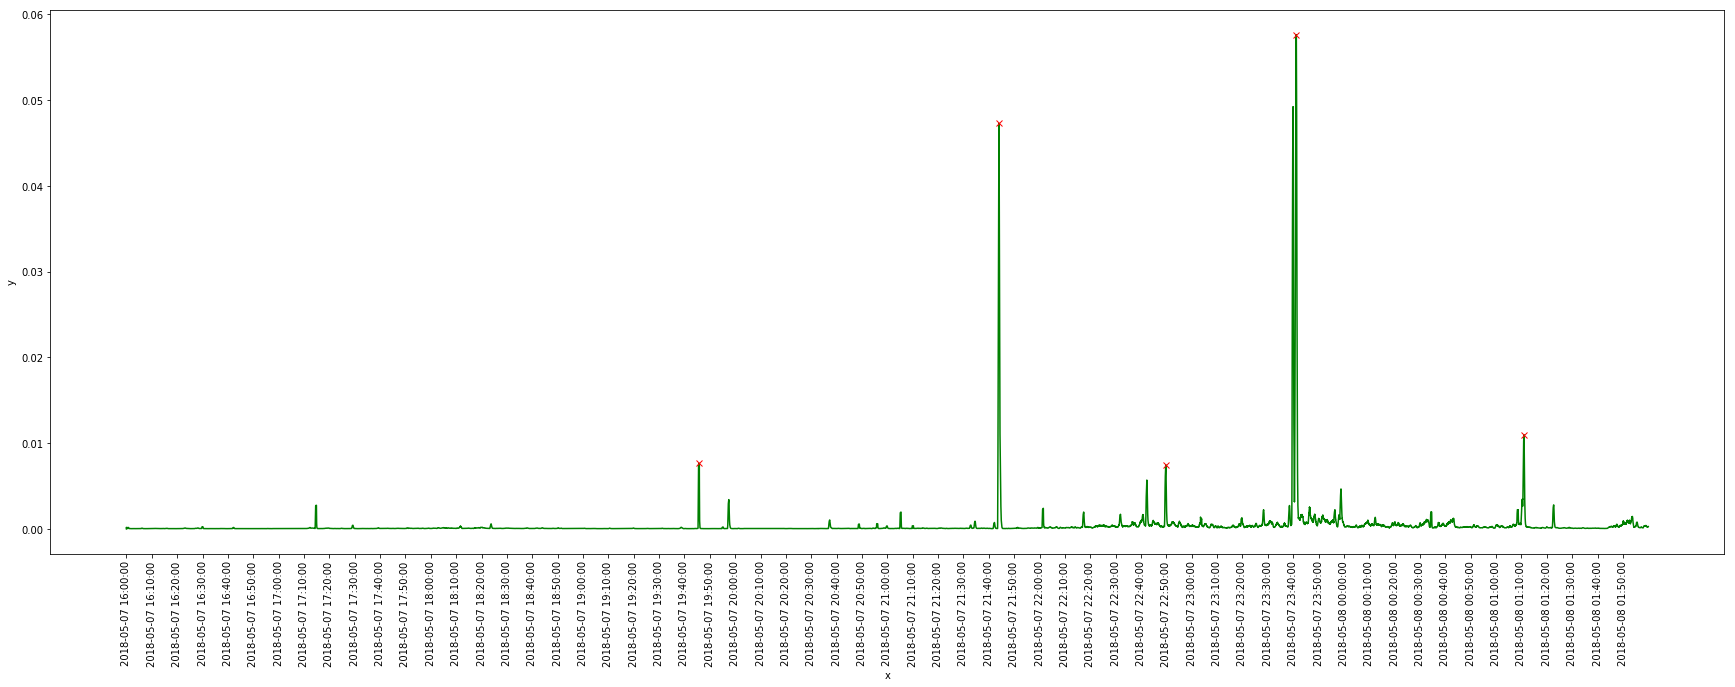

In [22]:
from matplotlib import pyplot as plt
fig, (ax1) = plt.subplots(1, 1, figsize=(30, 10))
ax1.plot(x_av,y_av, "g")
plt.xlabel('x')
plt.ylabel('y') 
plt.xticks(x_av[::60000], xticks, rotation=90)
ax1.plot(x_av[lpeaks], y_av[lpeaks], "rx")
#ax2.plot(cft)
plt.show()

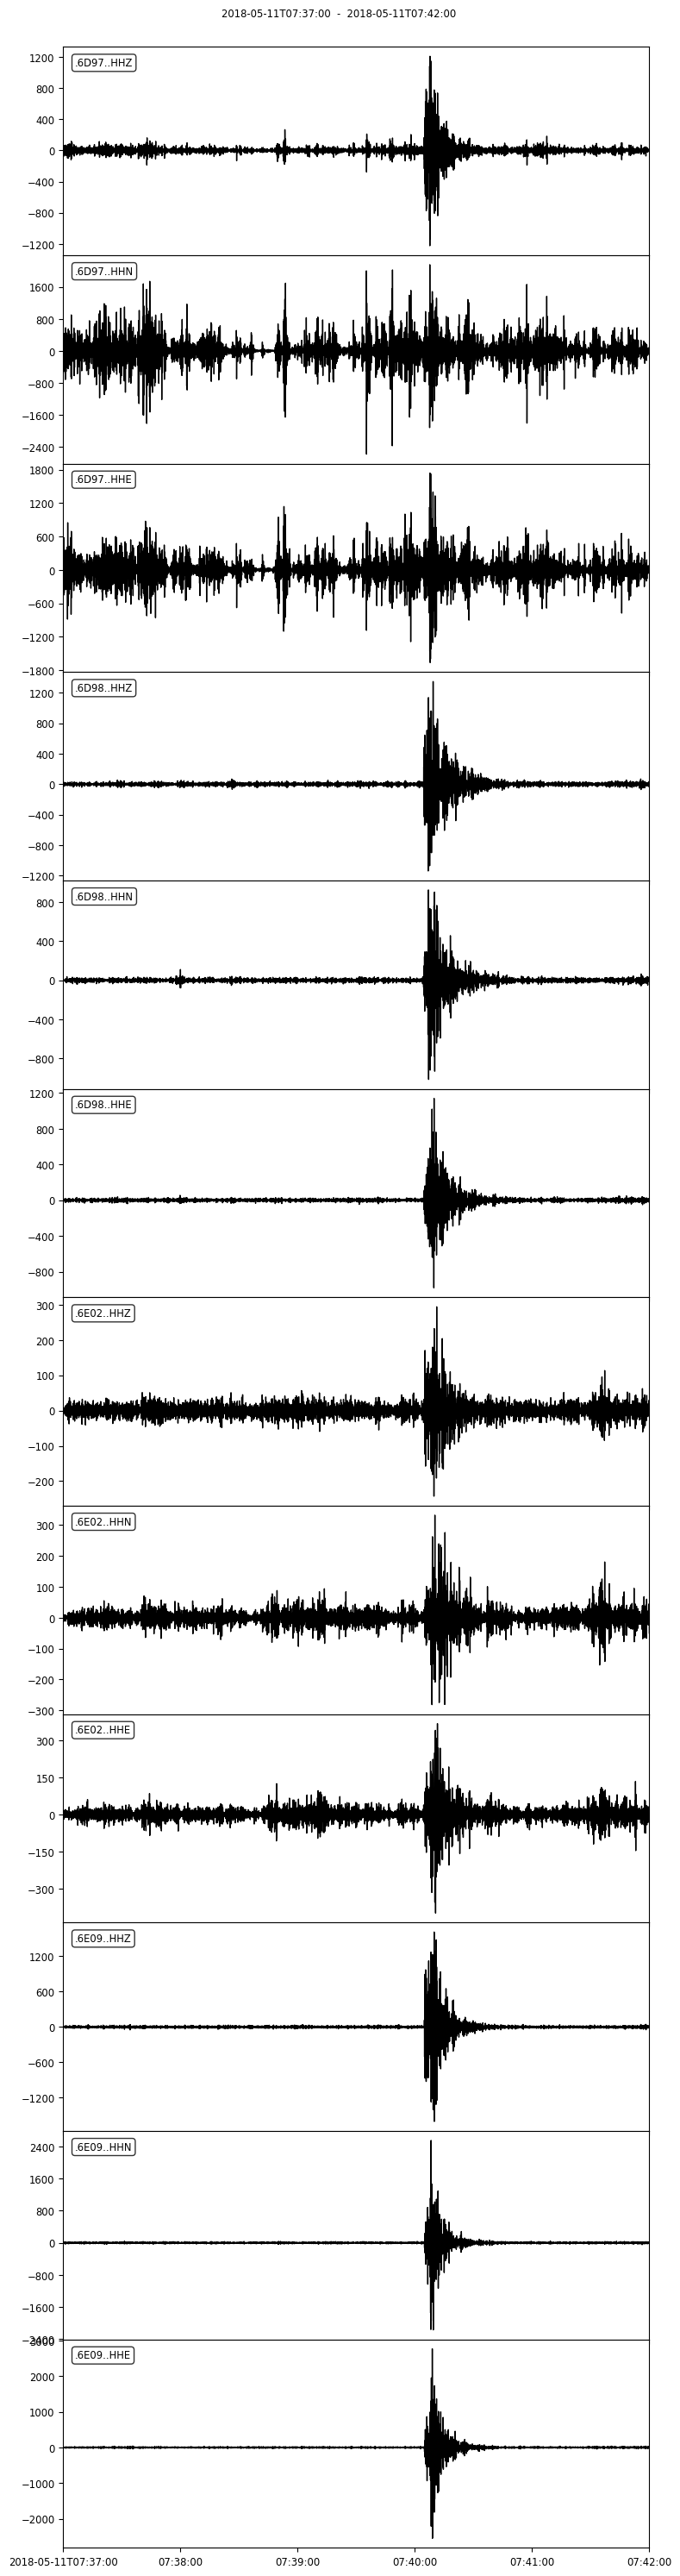

Wall time: 16.8 s


In [87]:
%%time
starttime = UTCDateTime('2018-05-11T07:37:00.000000Z')
endtime = UTCDateTime('2018-05-11T07:42:00.000000Z')
indStart = np.where(times==starttime)[0][0]
indEnd = np.where(times==endtime)[0][0]
copy = station_data.copy()
trimed = copy.trim(starttime=times[indStart], endtime=times[indEnd])
trimed.plot(equal_scale=False)

In [17]:
for i in range(len(filtered_times)):
    f_time = filtered_times[i]
    ind = np.where(times==f_time)[0][0]
    print('ind: {0}'.format(ind))
    startInd = ind - 1500
    endInd = ind + 3000
    copy = station_data.copy()
    trimed = copy.trim(starttime=times[startInd], endtime=times[endInd])
    print('trimed: {0}'.format(trimed))
    trimed.write("test{0}.msd".format(ind), format="MSEED")

ind: 1352229
trimed: 12 Trace(s) in Stream:
.6D97..HHE | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6D97..HHN | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6D97..HHZ | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6D98..HHE | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6D98..HHN | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6D98..HHZ | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6E02..HHE | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6E02..HHN | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6E02..HHZ | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samples
.6E09..HHE | 2018-05-07T19:45:07.290000Z - 2018-05-07T19:45:52.290000Z | 100.0 Hz, 4501 samp

C:\ProgramData\Anaconda3\lib\site-packages\obspy\io\mseed\core.py:772: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


ind: 2455826
trimed: 12 Trace(s) in Stream:
.6D97..HHE | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6D97..HHN | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6D97..HHZ | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6D98..HHE | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6D98..HHN | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6D98..HHZ | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6E02..HHE | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6E02..HHN | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6E02..HHZ | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samples
.6E09..HHE | 2018-05-07T22:49:03.260000Z - 2018-05-07T22:49:48.260000Z | 100.0 Hz, 4501 samp